In [2]:
import pandas as pd
import sklearn
import numpy as np


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt

from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.dummy import DummyClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import xgboost as xgb

In [4]:
pd.set_option("display.max_columns", 100)

In [5]:
from sklearn.base import TransformerMixin, BaseEstimator

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        
        self.key = key
        

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


Import the trimmed txn dataset - Removed columns that are predominanetly empty or have zero values

In [6]:
transactions_df = pd.read_csv('trimmed_transaction_dataset.csv')

In [7]:
transactions_df.head()

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,max value received,avg val received,min val sent,max val sent,avg val sent,min value sent to contract,max val sent to contract,avg value sent to contract,total transactions (including tnx to create contract,total Ether sent,total ether received,total ether sent contracts,total ether balance,Total ERC20 tnxs,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec addr,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,0.000000,45.806785,6.589513,0.00,31.220000,1.200681,0.0,0.0,0.0,810,865.691093,586.466675,0.0,-279.224419,265.0,3.558854e+07,3.560317e+07,0.0,30.0,54.0,0.0,58.0,0.0,1.500000e+07,265586.147600,0.000000,1.683100e+07,271779.920000,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,0.000000,2.613269,0.385685,0.00,1.800000,0.032844,0.0,0.0,0.0,102,3.087297,3.085478,0.0,-0.001819,8.0,4.034283e+02,2.260809e+00,0.0,1.0,5.0,0.0,7.0,0.0,3.650000e+02,57.632615,2.260809,2.260809e+00,2.260809,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,0.113119,1.165453,0.358906,0.05,3.538616,1.794308,0.0,0.0,0.0,12,3.588616,3.589057,0.0,0.000441,8.0,5.215121e+02,0.000000e+00,0.0,0.0,7.0,0.0,8.0,0.0,4.428198e+02,65.189009,0.000000,0.000000e+00,0.000000,0.0,8.0,None,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,0.000000,500.000000,99.488840,0.00,450.000000,70.001834,0.0,0.0,0.0,34,1750.045862,895.399559,0.0,-854.646303,14.0,1.711105e+04,1.141223e+04,0.0,2.0,11.0,0.0,11.0,0.0,1.141223e+04,1555.550174,100.000000,9.029231e+03,3804.076893,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,0.000000,12.802411,2.671095,0.00,9.000000,0.022688,0.0,0.0,0.0,4619,104.318883,53.421897,0.0,-50.896986,42.0,1.628297e+05,1.235399e+05,0.0,4.0,23.0,0.0,27.0,0.0,9.000000e+04,4934.232147,0.000000,4.500000e+04,13726.659220,6.0,27.0,StatusNetwork,EOS


In [8]:
transactions_df[' ERC20_most_rec_token_type'] = transactions_df[' ERC20_most_rec_token_type'].astype(str)

In [10]:
transactions_df = transactions_df.drop(['Address', 'Index', 'Unnamed: 0', ' ERC20_most_rec_token_type', ' ERC20 most sent token type'], axis=1)

In [11]:
y = transactions_df.pop('FLAG')

In [12]:
X = transactions_df

In [13]:
X_set, X_test, y_set, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_set, y_set, stratify=y_set, test_size=0.10, random_state=42)

In [15]:
print(len(X_train), len(X_test))

6465 1797


In [16]:
y_train.value_counts()

0    5493
1     972
Name: FLAG, dtype: int64

In [17]:
y_test.value_counts()

0    1527
1     270
Name: FLAG, dtype: int64

In [18]:
y_val.value_counts()

0    611
1    108
Name: FLAG, dtype: int64

In [61]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('ngram_text', Pipeline([
            ('selector', ItemSelector(key=' ERC20_most_rec_token_type')),
            ('vectorizer', CountVectorizer(ngram_range=(1,3), lowercase=True))
            #('tfidf_transformer',  TfidfVectorizer(ngram_range=(1, 8)))
        ]))
    ],
    
    )),
    #('classifier',  DecisionTreeClassifier(max_depth=256, criterion="entropy")) ])
    #('classifier',  LinearSVC(C=0.1, verbose = 2, max_iter=2000)) ])
    #('classifier', MultinomialNB(alpha=0.1))])
    #('classifier', GaussianNB())])
   # ('classifier',  LogisticRegression()) ])
    ('classifier',  RandomForestClassifier()) ])
    #('classifier', DecisionTreeClassifier(max_depth=8)) ])
    #('classifier',  SVC(kernel='linear', gamma=0.1)) ])

In [75]:
def createPipeline(column_name, classifier):
    pipeline = Pipeline([
        ('features', FeatureUnion([
            ('ngram_text', Pipeline([
                ('selector', ItemSelector(key=column_name)),
                ('vectorizer', CountVectorizer(ngram_range=(1,3), lowercase=True))
                #('tfidf_transformer',  TfidfVectorizer(ngram_range=(1, 8)))
            ]))
        ],
        
        )),
        #('classifier',  DecisionTreeClassifier(max_depth=256, criterion="entropy")) ])
        #('classifier',  LinearSVC(C=0.1, verbose = 2, max_iter=2000)) ])
        #('classifier', MultinomialNB(alpha=0.1))])
        #('classifier', GaussianNB())])
        ('classifier',  classifier) ])
        #('classifier',  RandomForestClassifier()) ])
        #('classifier', DecisionTreeClassifier(max_depth=8)) ])
        #('classifier',  SVC(kernel='linear', gamma=0.1)) ])
    return pipeline

In [84]:
log_reg_pipe = createPipeline(' ERC20_most_rec_token_type', LogisticRegression())
forest_pipe = createPipeline(' ERC20_most_rec_token_type', RandomForestClassifier())
linearsvc_pipe = createPipeline(' ERC20_most_rec_token_type', LinearSVC())
baseline_pipe = createPipeline(' ERC20_most_rec_token_type', DummyClassifier(strategy='most_frequent', random_state=0))


In [57]:
models = [('LR',LogisticRegression()), ('RF',RandomForestClassifier()),('XGB',xgb.XGBClassifier()), ('LSVC',LinearSVC()), ('BASE',DummyClassifier(strategy='most_frequent', random_state=0))]

In [58]:
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc', 'f1']
results = []
names = []
target_names = ['0', '1']
dfs = []

In [59]:
for name, model in models:
    skfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=45)
    cv_results = model_selection.cross_validate(model, X_set, y_set, cv=skfold, scoring=scoring)
    clf = model.fit(X_set, y_set)
    y_pred = clf.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names))
    results.append(cv_results)
    names.append(name)
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)

    
final = pd.concat(dfs, ignore_index=True)

/Users/roryduthie/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/roryduthie/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

LR
              precision    recall  f1-score   support

           0       0.88      1.00      0.94      1527
           1       1.00      0.21      0.35       270

    accuracy                           0.88      1797
   macro avg       0.94      0.61      0.64      1797
weighted avg       0.90      0.88      0.85      1797

RF
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1527
           1       0.99      0.91      0.95       270

    accuracy                           0.99      1797
   macro avg       0.99      0.96      0.97      1797
weighted avg       0.99      0.99      0.99      1797

[10:58:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the

[10:58:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the

[10:58:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the

[10:58:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the

[10:58:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the

[10:58:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1527
           1       0.97      0.95      0.96       270

    accuracy                           0.99      1797
   macro avg       0.98      0.97      0.98      1797
weighted avg       0.99      0.99      0.99      1797



/Users/roryduthie/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/roryduthie/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/roryduthie/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/roryduthie/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/roryduthie/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LSVC
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1527
           1       0.67      0.29      0.40       270

    accuracy                           0.87      1797
   macro avg       0.78      0.63      0.67      1797
weighted avg       0.85      0.87      0.85      1797

BASE
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1527
           1       0.00      0.00      0.00       270

    accuracy                           0.85      1797
   macro avg       0.42      0.50      0.46      1797
weighted avg       0.72      0.85      0.78      1797



/Users/roryduthie/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/roryduthie/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/roryduthie/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/roryduthie/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sa

In [22]:
final.head()

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,test_f1,model
0,0.186282,0.009733,0.867780,0.882390,0.867780,0.826863,0.631883,0.301471,LR
1,0.102079,0.007799,0.839944,0.812394,0.839944,0.768880,0.639508,0.017094,LR
2,0.106403,0.009273,0.898399,0.906429,0.898399,0.869080,0.654887,0.359649,LR
3,0.112367,0.007517,0.877523,0.892997,0.877523,0.840826,0.637958,0.333333,LR
4,0.102834,0.009405,0.864206,0.882880,0.864206,0.811904,0.632801,0.155844,LR


In [60]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')

In [61]:
time_metrics = ['fit_time','score_time'] # fit time metrics

results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')

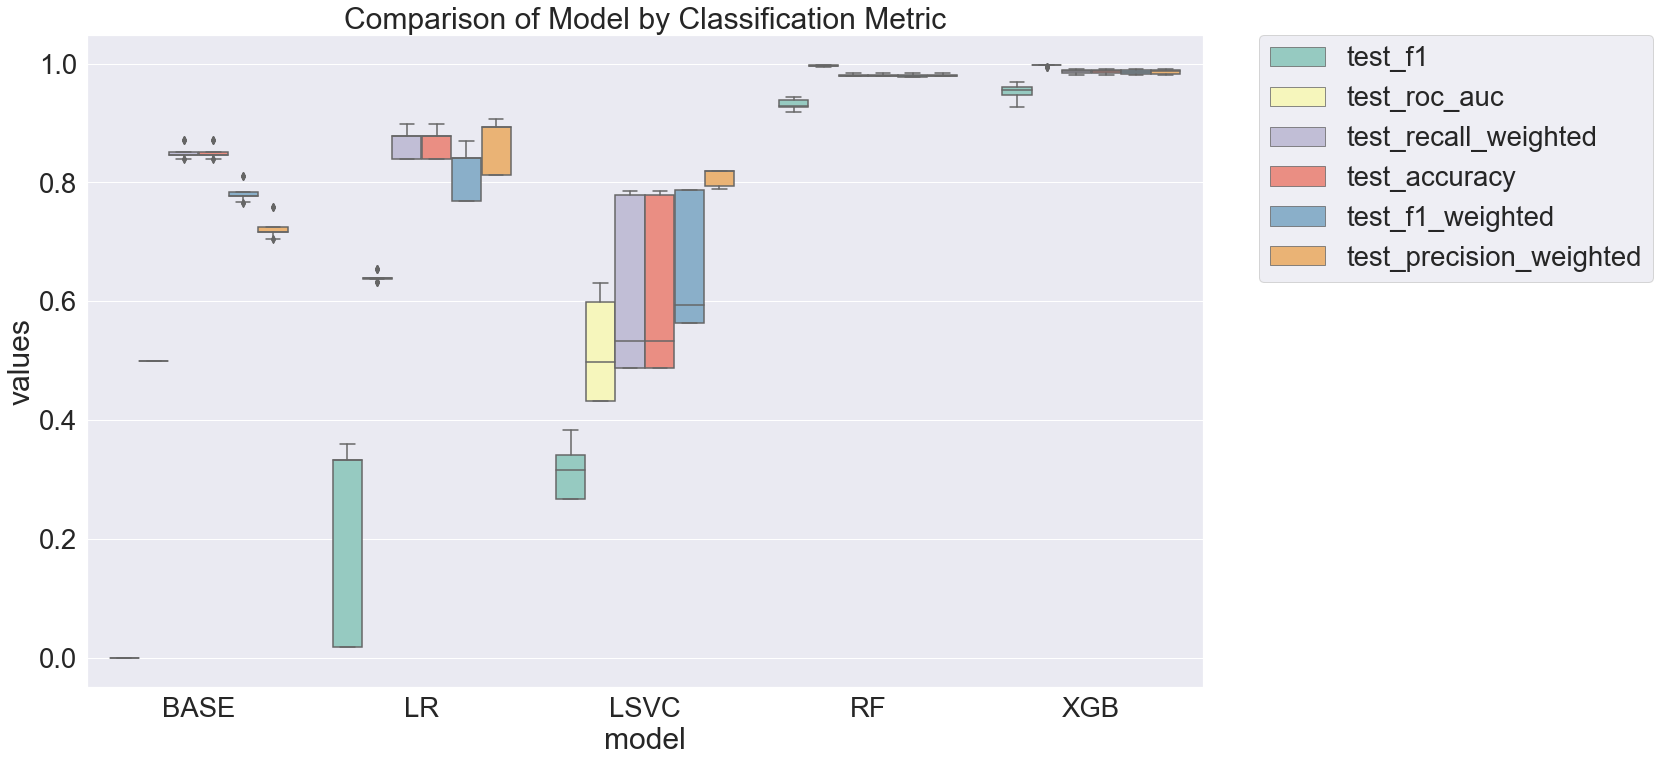

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

In [29]:
def evaluateTestSet(x_train, x_test, y_train, y_test, model):
    clf = model.fit(x_train, y_train)
    y_pred = clf.predict(x_test)

    print(classification_report(y_test, y_pred, target_names=target_names))
    print(confusion_matrix(y_test,y_pred))
    return model  

In [30]:
evaluateTestSet(X_set, X_test, y_set, y_test, RandomForestClassifier())

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1527
           1       0.98      0.91      0.94       270

    accuracy                           0.98      1797
   macro avg       0.98      0.95      0.97      1797
weighted avg       0.98      0.98      0.98      1797

[[1522    5]
 [  25  245]]


RandomForestClassifier()

In [63]:
evaluateTestSet(X_set, X_test, y_set, y_test, xgb.XGBClassifier())

/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:00:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1527
           1       0.97      0.95      0.96       270

    accuracy                           0.99      1797
   macro avg       0.98      0.97      0.98      1797
weighted avg       0.99      0.99      0.99      1797

[[1520    7]
 [  14  256]]


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Box plot shows that Random Forest works the best on the validation sets. So portion off a validation set and look at the feature importance and see if removing features will help

In [42]:
model = evaluateTestSet(X_train, X_val, y_train, y_val, RandomForestClassifier())

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       611
           1       1.00      0.91      0.95       108

    accuracy                           0.99       719
   macro avg       0.99      0.95      0.97       719
weighted avg       0.99      0.99      0.99       719

[[611   0]
 [ 10  98]]


In [43]:
from boruta import BorutaPy

In [45]:
# define Boruta feature selection method
feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features
feat_selector.fit(X_train.values, y_train.values)

# check selected features
feat_selector.support_

# check ranking of features
feat_selector.ranking_

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	30
Tentative: 	2
Rejected: 	6
Iteration: 	9 / 100
Confirmed: 	30
Tentative: 	2
Rejected: 	6
Iteration: 	10 / 100
Confirmed: 	30
Tentative: 	2
Rejected: 	6
Iteration: 	11 / 100
Confirmed: 	30
Tentative: 	2
Rejected: 	6
Iteration: 	12 / 100
Confirmed: 	31
Tentative: 	1
Rejected: 	6
Iteration: 	13 / 100
Confirmed: 	31
Tentative: 	1
Rejected: 	6
Iteration: 	14 / 100
Confirmed: 	31
Tentative: 	1
Rejected: 	6
Iteration: 	15 / 100
Confirmed: 	31
Tentative: 	1
Rejected: 	6
Iteration: 	16 / 100
Confirmed: 	31
Tentative: 	1
Rejected: 	6
I

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 1, 1, 1, 5, 1,
       1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [46]:
feature_ranks = list(zip(X_train.columns, feat_selector.ranking_, feat_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: Avg min between sent tnx  Rank: 1,  Keep: True
Feature: Avg min between received tnx Rank: 1,  Keep: True
Feature: Time Diff between first and last (Mins) Rank: 1,  Keep: True
Feature: Sent tnx                  Rank: 1,  Keep: True
Feature: Received Tnx              Rank: 1,  Keep: True
Feature: Number of Created Contracts Rank: 1,  Keep: True
Feature: Unique Received From Addresses Rank: 1,  Keep: True
Feature: Unique Sent To Addresses  Rank: 1,  Keep: True
Feature: min value received        Rank: 1,  Keep: True
Feature: max value received        Rank: 1,  Keep: True
Feature: avg val received          Rank: 1,  Keep: True
Feature: min val sent              Rank: 1,  Keep: True
Feature: max val sent              Rank: 1,  Keep: True
Feature: avg val sent              Rank: 1,  Keep: True
Feature: min value sent to contract Rank: 5,  Keep: False
Feature: max val sent to contract  Rank: 5,  Keep: False
Feature: avg value sent to contract Rank: 5,  Keep: False
Feature: total tran

In [48]:
features = [f for f in X_train.columns]

In [49]:
final_features = list()
indexes = np.where(feat_selector.support_ == True)
for x in np.nditer(indexes):
    final_features.append(features[x])
print(final_features)

['Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'Unique Sent To Addresses', 'min value received', 'max value received ', 'avg val received', 'min val sent', 'max val sent', 'avg val sent', 'total transactions (including tnx to create contract', 'total Ether sent', 'total ether received', 'total ether balance', ' Total ERC20 tnxs', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 uniq sent addr', ' ERC20 uniq rec addr', ' ERC20 uniq rec contract addr', ' ERC20 min val rec', ' ERC20 max val rec', ' ERC20 avg val rec', ' ERC20 min val sent', ' ERC20 max val sent', ' ERC20 avg val sent', ' ERC20 uniq sent token name', ' ERC20 uniq rec token name']


In [50]:
model = evaluateTestSet(X_train[final_features], X_val[final_features], y_train, y_val, RandomForestClassifier())

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       611
           1       1.00      0.93      0.96       108

    accuracy                           0.99       719
   macro avg       0.99      0.96      0.98       719
weighted avg       0.99      0.99      0.99       719

[[611   0]
 [  8 100]]


In [51]:
model = evaluateTestSet(X_set[final_features], X_test[final_features], y_set, y_test, RandomForestClassifier())

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1527
           1       0.99      0.90      0.94       270

    accuracy                           0.98      1797
   macro avg       0.99      0.95      0.97      1797
weighted avg       0.98      0.98      0.98      1797

[[1525    2]
 [  27  243]]


## Follow the same steps for XGBoost

In [64]:
model = evaluateTestSet(X_train, X_val, y_train, y_val, xgb.XGBClassifier())

/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:03:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       611
           1       0.97      0.91      0.94       108

    accuracy                           0.98       719
   macro avg       0.98      0.95      0.96       719
weighted avg       0.98      0.98      0.98       719

[[608   3]
 [ 10  98]]


In [65]:
feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)

# find all relevant features
feat_selector.fit(X_train.values, y_train.values)

# check selected features
feat_selector.support_

# check ranking of features
feat_selector.ranking_

/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:04:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
[11:04:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
[11:04:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Iteration: 	3 / 100
Conf

array([ 3,  1,  1,  2,  1,  1,  1, 10,  8, 12,  1,  1, 13, 13, 19, 19, 19,
        1, 16,  1, 19,  6,  1,  1,  1, 19,  8,  1, 19,  4,  1, 10,  2,  1,
        5,  7,  1, 15])

In [66]:
feature_ranks = list(zip(X_train.columns, feat_selector.ranking_, feat_selector.support_))

# iterate through and print out the results
for feat in feature_ranks:
    print('Feature: {:<25} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))

Feature: Avg min between sent tnx  Rank: 3,  Keep: False
Feature: Avg min between received tnx Rank: 1,  Keep: True
Feature: Time Diff between first and last (Mins) Rank: 1,  Keep: True
Feature: Sent tnx                  Rank: 2,  Keep: False
Feature: Received Tnx              Rank: 1,  Keep: True
Feature: Number of Created Contracts Rank: 1,  Keep: True
Feature: Unique Received From Addresses Rank: 1,  Keep: True
Feature: Unique Sent To Addresses  Rank: 10,  Keep: False
Feature: min value received        Rank: 8,  Keep: False
Feature: max value received        Rank: 12,  Keep: False
Feature: avg val received          Rank: 1,  Keep: True
Feature: min val sent              Rank: 1,  Keep: True
Feature: max val sent              Rank: 13,  Keep: False
Feature: avg val sent              Rank: 13,  Keep: False
Feature: min value sent to contract Rank: 19,  Keep: False
Feature: max val sent to contract  Rank: 19,  Keep: False
Feature: avg value sent to contract Rank: 19,  Keep: False
Featu

In [67]:
final_features = list()
indexes = np.where(feat_selector.support_ == True)
for x in np.nditer(indexes):
    final_features.append(features[x])
print(final_features)

['Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Received Tnx', 'Number of Created Contracts', 'Unique Received From Addresses', 'avg val received', 'min val sent', 'total transactions (including tnx to create contract', 'total ether received', ' Total ERC20 tnxs', ' ERC20 total Ether received', ' ERC20 total ether sent', ' ERC20 uniq rec addr', ' ERC20 min val rec', ' ERC20 min val sent', ' ERC20 uniq sent token name']


In [68]:
model = evaluateTestSet(X_set[final_features], X_test[final_features], y_set, y_test, xgb.XGBClassifier())

/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/roryduthie/.pyenv/versions/3.8.1/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[11:06:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1527
           1       0.98      0.93      0.95       270

    accuracy                           0.99      1797
   macro avg       0.98      0.96      0.97      1797
weighted avg       0.99      0.99      0.99      1797

[[1521    6]
 [  19  251]]
